# Dataset Exploration

Kyler Nelson uses ShipRS in his POSEIDON-SAT project. However, the training set is limited. To bolster the training set, figure out how many images and instances there are of the Fishing Vessel class. YOLOv5 recommends at least **1,500** images per class and **10,000** instances (labeled objects) per class.

### First, let's find out these figures for the xView Dataset.

In [29]:
import json
import matplotlib.pyplot as plt
import os
from shiprsimagenet import ShipRSImageNet

In [2]:
geojson_file = os.path.join("xView", "xView_train.geojson")
class_labels_file = os.path.join("xView", "xview_class_labels.txt")

In [3]:
def load_geojson(file_path):
    with open(file_path, "r") as f:
        return json.load(f)
    
data = load_geojson(geojson_file)
features = data["features"]

In [4]:
def map_class_ids_to_names(class_labels_file):
    class_id_to_name = {} # Key = class id (int) | Value = corresponding class name (string)
    with open(class_labels_file, "r") as f:
        for line in f:
            # Lines in xview_class_labels.txt look like this: "11:Fixed-wing Aircraft"
            # Therefore, strip line of whitespace and split at the first colon
            class_id, class_name = line.strip().split(":", 1)
            class_id_to_name[int(class_id)] = class_name
    return class_id_to_name

class_id_to_name = map_class_ids_to_names(class_labels_file)

Determine the number of images per class. YOLOv5 recommends at least 1,500

In [5]:
def get_images_per_class(features, class_id_to_name):
    images_per_class = {} # Key = class name (string) | Value = a set of images containing instances of the class 
    invalid_images = set() # Images that contain unidentifiable classes

    for feature in features: 
        image_id = feature["properties"]["image_id"]
        if (feature["properties"]["type_id"] in class_id_to_name):
            # The class ID is valid
            class_name = class_id_to_name[ feature["properties"]["type_id"] ]
            if (class_name not in images_per_class):
                # First time encountering this image--initialize a set with first instance's class name
                images_per_class[class_name] = {image_id}
            else:
                images_per_class[class_name].add(image_id)
        else:
            #print(f"Class id {class_id} found in image {image_id} doesn't have a corresponding class name. Exporting to invalid_images.txt")
            invalid_images.add(image_id)
    
    # Write all the invalid images to a txt file
    # These images don't have class IDs that don't correspond to anything we know of
    with open("invalid_images.txt", "w") as f:
        for image in invalid_images:
            f.write(f"{image}\n")

    return images_per_class 

images_per_class = get_images_per_class(features, class_id_to_name)

# Associates each classname with the NUMBER of images per class rather than the individual URLs 
for key, val in images_per_class.items():
    images_per_class[key] = len(val)

Determine the number of instances belonging to each class

In [6]:
def get_instances_per_class(features, class_id_to_name):
    instances_per_class = {}
    
    for feature in features:
        class_id = feature["properties"]["type_id"]
        if (class_id in class_id_to_name):
            instances_per_class[class_id_to_name[class_id]] = instances_per_class.get(class_id_to_name[class_id], 0) + 1
    
    return instances_per_class

instances_per_class = get_instances_per_class(features, class_id_to_name)

Plot these results in Matplot

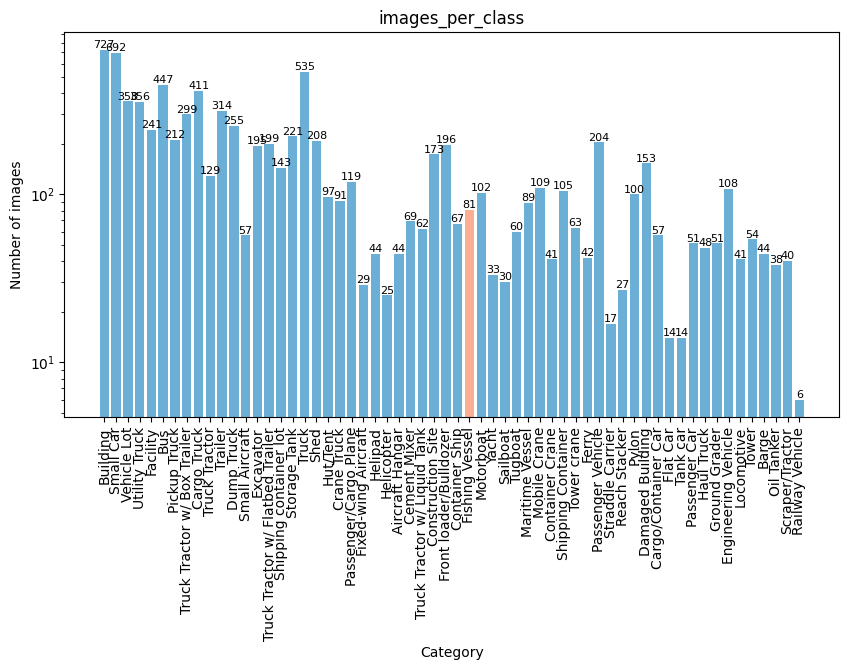

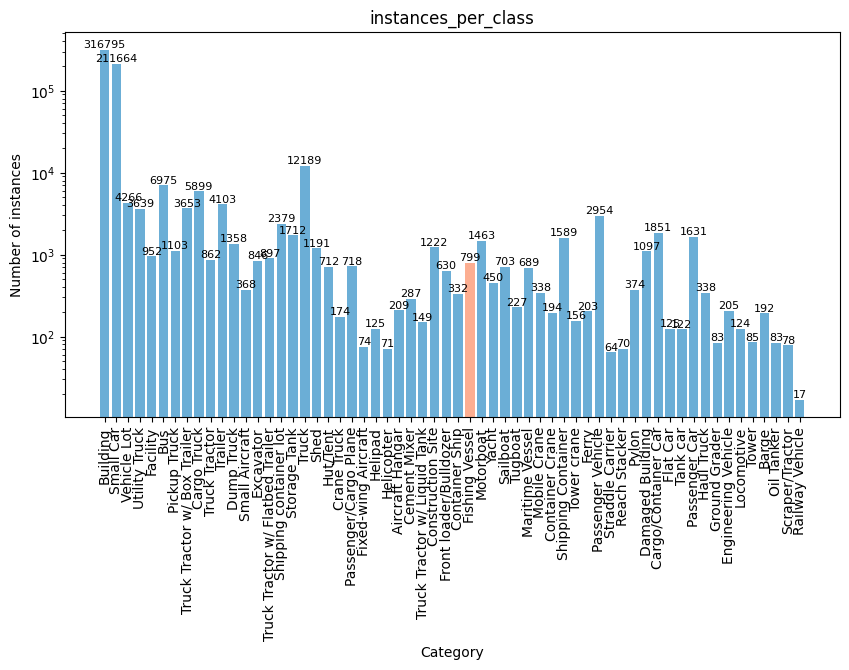

In [7]:
def plot(distribution, title, y):
    class_names = list(distribution.keys())
    counts = list(distribution.values())
    
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.xlabel("Category")
    plt.ylabel(y)
    plt.xticks(rotation=90)

    colors = ["#6baed6" if category != "Fishing Vessel" else "#fcae91" for category in class_names]
    bars = plt.bar(class_names, counts, log=True, width=0.8, color=colors)

    # Add labels ontop of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f"{int(yval)}", ha="center", va="bottom", fontsize=8)
    
plot(images_per_class, "images_per_class", "Number of images")
plot(instances_per_class, "instances_per_class", "Number of instances")

Write the image paths of theses 81 images containing fishing vessels into a text file for further analysis

In [30]:
fishing_vessel_images = set()

for feature in features:
    class_id = feature["properties"]["type_id"]
    image_id = feature["properties"]["image_id"]
    if (class_id == 47):
        fishing_vessel_images.add(image_id)

with open("fishing_vessel_xview.txt", "w") as f:
    for image in fishing_vessel_images:
        f.write(f"{image}\n")

### Now, let's find out these figures for the ShipRS Dataset.

In [13]:
dataset = ShipRSImageNet("ShipRSImageNet_V1")
train_set = dataset.get_image_set("train")
test_set = dataset.get_image_set("test")
trainval_set = dataset.get_image_set("trainval")
val_set = dataset.get_image_set("val")

In [33]:
fishing_vessel_images = set()

In [34]:
def get_fishing_vessel_image(imageset):
    instances = 0
    
    for image in imageset:
        if image:
            for obj in image.objects:
                if obj.name == "Fishing Vessel":
                    fishing_vessel_images.add(image.file_path[40:])
                    instances += 1
    
    return instances

In [35]:
train_instances = get_fishing_vessel_image(train_set)
trainval_instances = get_fishing_vessel_image(trainval_set)
val_instances = get_fishing_vessel_image(val_set)
print(f"Total instances across ImageSets = {train_instances+trainval_instances+val_instances}")

Total instances across ImageSets = 834


In [36]:
with open("fishing_vessel_shiprs.txt", "w") as f:
    for image in fishing_vessel_images:
        f.write(f"{image}\n")